In [13]:
import numpy as np
import cv2
import random
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Reshape
from sklearn.model_selection import train_test_split

width, height = 200, 200
num_circles = 2
noise_level = 10
num_images = 10000



min_radius = width*0.02
max_radius = width*0.20


truth = np.zeros((num_circles,3))
target = np.zeros((num_images,num_circles,3))
images = np.zeros((num_images, height, width), dtype=np.uint8)

for i in range(num_images):
    circle_centers = []
    img = np.zeros((height, width), dtype=np.uint8)
    for _ in range(num_circles):
    
        while True:
            # Generate random circle center and radius
            x = random.randint(max_radius, width - max_radius)
            y = random.randint(max_radius, height - max_radius)
            radius = random.randint(min_radius, max_radius)
            thickness = np.random.randint(0.1, 1)
#             thickness = 1

            # Check if the new circle overlaps with any of the previous circles
            overlap = False
            for center, r in circle_centers:
                distance = np.sqrt((x - center[0])**2 + (y - center[1])**2)
                if distance <= r + radius:
                    overlap = True
                    break

            # If no overlap, add the circle to the image and break the loop
            if not overlap:
                circle_centers.append(((x, y), radius))
                color = (random.randint(128, 255))
                cv2.circle(img, (x, y), radius, color, thickness)
                truth[_,:]=[x, y, radius]
                break
                
    noise = np.random.normal(0, noise_level, (height, width)).astype(np.float32)
    noisy_img = img.astype(np.float32) + noise
    noisy_img = np.clip(noisy_img, 0, 255).astype(np.uint8)
    target[i,:,:]=truth
    images[i, :, :] = noisy_img

target = np.reshape(target, (num_images,num_circles*3))
target.shape

(10000, 6)

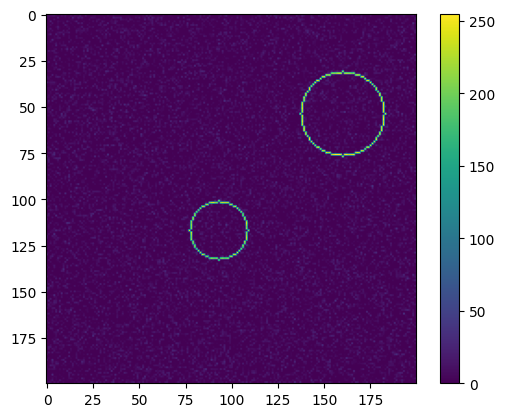

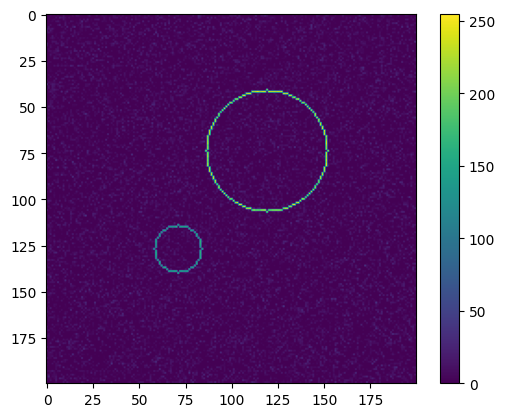

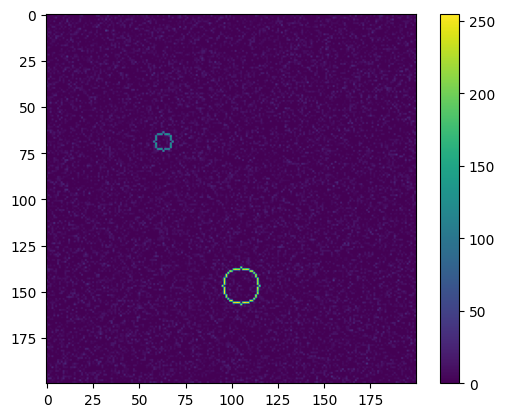

In [14]:
for i in range(3):
    im1 = images[i,:,:]
    plt.imshow(im1)
    plt.clim([0,255])
    plt.colorbar()
    plt.show()

In [15]:
images = images/255
target = target/width

x_train, x_val, y_train, y_val = train_test_split(images, target, test_size=0.2, random_state=42)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(height, width, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_circles*3), # Output layer with 12 units for the x and y coordinates of six circles
#     Reshape((num_circles, 2)) # Reshape the output to a 2x6 matrix
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 198, 198, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 99, 99, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 46, 46, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 23, 23, 128)     

In [16]:
def custom_mse(y_true, y_pred):
    y_true_reshaped = tf.reshape(y_true, (-1, num_circles, 3))
    y_pred_reshaped = tf.reshape(y_pred, (-1, num_circles, 3))
    y_true_sorted = tf.gather(y_true_reshaped, tf.argsort(y_true_reshaped[:, :, 1]), batch_dims=1)
    y_pred_sorted = tf.gather(y_pred_reshaped, tf.argsort(y_pred_reshaped[:, :, 1]), batch_dims=1)

    return tf.reduce_mean(tf.square(y_true_sorted - y_pred_sorted))

In [ ]:
model.compile(optimizer='adam', loss=custom_mse)

# Train the model
history = model.fit(x_train, y_train, epochs=30, batch_size = 32, validation_data=(x_val, y_val))

Epoch 1/30
250/250 [==============================] - 135s 539ms/step - loss: 0.0168 - val_loss: 0.0048
Epoch 2/30
250/250 [==============================] - 143s 571ms/step - loss: 0.0033 - val_loss: 0.0027
Epoch 3/30
250/250 [==============================] - 146s 585ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 4/30
250/250 [==============================] - 147s 588ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 5/30
250/250 [==============================] - 145s 581ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 6/30
250/250 [==============================] - 146s 585ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 7/30
250/250 [==============================] - 144s 577ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 8/30
250/250 [==============================] - 147s 587ms/step - loss: 9.9378e-04 - val_loss: 0.0014
Epoch 9/30
250/250 [==============================] - 145s 581ms/step - loss: 9.3628e-04 - val_loss: 0.0013
Epoch 10/30
250/250 [==============================] - 1

In [ ]:
test_predictions = model.predict(x_val)
# test_predictions = np.round(test_predictions).flatten()

In [ ]:
imnum = 20
plt.imshow(x_val[imnum,:,:])
plt.show

In [ ]:
predictedXY = test_predictions[imnum,:]
predictedXY = np.reshape(predictedXY,(num_circles,3))
# predictedXY = np.round(predictedXY).astype(int)
predictedXY = np.round(predictedXY*width).astype(int)

imgg = x_val[imnum,:,:]

for i in range(num_circles):
    x = predictedXY[i,0]
    y = predictedXY[i,1]
    radius = predictedXY[i,2]
    cv2.circle(imgg, (x, y), radius, 125, 1)
plt.imshow(imgg)

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plot the training and validation loss
plt.plot(epochs, train_loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()